# Prediction of Nighttime NO2

## Background

### Names and Acronyms
1) ASDC: [Atmosperhic Science Data Center](https://asdc.larc.nasa.gov/about)
1) PGN (Pandora): [Pandonia Global Network](https://www.pandonia-global-network.org/) / [Pandora](https://pandora.gsfc.nasa.gov/About/)
    - **NOTE**: NASA's portion of the PGN is known as Pandora.  Within the scope of this notebook, Pandora and PGN may be used interchangably as this project will only use NASAs PGN site data.
1) TEMPO: [Troposoperic Emissions: Monitoring of Pollution](https://science.nasa.gov/mission/tempo/)

### Resources
1) ASDC Data Processing Tool (Version 1)
    - This notebook was published by the ASDC and provides examples of how to correctly load and use Pandora and TEMPO data.
    - https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb
1) PGN Station Map
    - A map showing the location of all PGN groundsites.
    - https://blickm.hetzner.pandonia-global-network.org/livemaps/pgn_stationsmap.png


This notebook borrows heavily from and extens the functionality of the NASA, ASDC Data and User Servicies notebook found here:

https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb

This notebook intends to test the hypothesis that a model can be built with Pandora which can predict nightitme NO<sub>2</sub> and that that model can be applied to TEMPO daytime measurments to predict NO<sub>2</sub> for any location covered by TEMPO.



## 1. Environment Setup

### Environment Setup
There are many tools available such as [poetry](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://python-poetry.org/&ved=2ahUKEwjr9aLgna6QAxX5EVkFHVsNBMUQFnoECBsQAQ&usg=AOvVaw3Jp8q7OO7XkcY8Tq4tDe30) and [uv](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://docs.astral.sh/uv/&ved=2ahUKEwiP9aXVna6QAxVyF1kFHeyTNGYQFnoECAsQAQ&usg=AOvVaw2VJVt0jrah2S9tIgdc1yRc) that simplify and speed up environment setup.  For simplicity, this guide only covers the method built into the python standard library.
1) Install [Python 3.11](https://www.python.org/downloads/) (or higher)
1) (Recomended) Create a virtual environment (learn more [here](https://docs.python.org/3/library/venv.html))
1) Install the required packages using the following command.<br>`% pip install pyproject.toml`
1) Select the newly created kernal in your notebook.
    - NOTE: this varies slightly between notebook tools, but in almost all tools you will be prompted to select a kernal upon running a cell.

### Import required modules

Common imports that are used throughout.  Other packages will be imported as needed.

In [60]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

### Data Access
In order to access data, you will need an Earthdata Login account.  If you do not have an Earthdata Login account, you can create one here:<br>
https://urs.earthdata.nasa.gov/

The earthaccess module allows you to authenticate.  Multilple login options exist for providing your credentials, you can read more on options here:<br>
https://pypi.org/project/earthaccess/<br>
By unless another option is configured, you will be prompted by your notebook to enter your credentials.

In [61]:
import earthaccess


earthaccess.login()

Notebook Settings

In [62]:
PGN_DATA_DIR = Path('pgn-data')
PGN_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
PGN_DATA_PATH = PGN_DATA_DIR.joinpath('pgn-data.csv')
TEMPO_DATA_DIR = Path('tempo-data')
TEMPO_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
TEMPO_DATA_PATH = TEMPO_DATA_DIR.joinpath('tempo-data.csv')

Optionally, clean data stores, since data is filtered by time and site, data shoudl be removed when times or sites change.

In [63]:
# if CLEAN is True, removes all stored data.
CLEAN_PGN = True
CLEAN_TEMPO = False

if CLEAN_PGN:
    for file in PGN_DATA_DIR.iterdir():
        file.unlink()
if CLEAN_TEMPO:
    for file in TEMPO_DATA_DIR.iterdir():
        file.unlink()

## 1. Data Prepairation

### 1.1. Download Data

**Data Ingest Workflow**
1) Collect the URLs for relivant files.
1) If not already downloaded, download the files.
1) If not already parsed, parse the files and save them as dataframes.
1) Return a list of relivant file paths

**Notes**
- PGN and TEMPO files are saved to the PGN_DATA_DIR and TEMPO_DATA_DIR directories.
- This system allows new files to be added while old files are still used, when available.
- TEMPO files are VERY large, a full year of data for 3 PGN sites takes up 100GB of hard drive space.
- Running for a shorter time period does not delete data, it only uses a smaller subset of files ensuring that short time frames can be used for testing.
- Though VERY slow to run initially, subsiquent runs for the same or smaller data subsets are fairly fast.

#### 1.1.1. Define Download Settings

In [64]:
# July 21, 2024 was a full moon, which should provide high quality Lunar PGN NO2 Readings.
start_date = datetime(2024, 7, 15)
end_date = datetime(2024, 7, 25)

#### 1.1.1. Download Pandora data

Pandora settings

You can find all Pandora daytime data [here](https://data.pandonia-global-network.org), nighttime data must be acquired from the [API](https://api.hetzner.pandonia-global-network.org/docs#/).

For more information about PGN codes and columns, see the file header.

In [83]:
daytime_suffix = 'rnvh3p1-8.txt'
nightitme_suffix = 'rnvm2p1-8.txt'
pgn_formats = {
    # daytime file format
    daytime_suffix: {
        'cycle': 'Day',
        'suffix': 'rnvh3p1-8.txt',
        'no2_quality_flag_index': 52,
        'valid_quality_flags': [0, 10],
        'column_index': 61,
        'column_unc_index': 62,
    },
    # nighttime file format
    nightitme_suffix: {
        'cycle': 'Night',
        'suffix': 'rnvm2p1-8.txt',
        'no2_quality_flag_index': 35,
        'valid_quality_flags': [0, 1, 10, 11, 12],
        'column_index': 38,
        'column_unc_index': 39,
    },
}

# sites = ['BronxNY', 'BuffaloNY', 'QueensNY']
# site with known daytime and nighttime data
sites = {'WashingtonDC', 'HamptonVA'}

#### 1.1.1.3 Get PGN Files

An API must be used to download the daytime and nighttime files where they exist.  Not all sites are set up to take nighttime readings.

You can read more about the API here:<br>
https://api.hetzner.pandonia-global-network.org/docs#/v1%2Ffiles/location_v1_files__location__get

For each location, search each instrument and spectrometer for applicable files.

In [84]:
import requests


BASE_URL = "https://api.ovh.pandonia-global-network.org/v1/files"
headers = {"X-API-Key": "kWKkafU6BfyO9vGQbso_o-LZYOZTL6IOaFLtdj8dIpQ"}  # Add your API key here

pgn_urls: list[str] = []
for s, site in enumerate(sites):
    print("Processing site", s+1, 'of', len(sites), site)
    instruments = requests.get(f"{BASE_URL}/{site}",  headers=headers).json()
    for i, instrument in enumerate(instruments):
        print("\tProcessing instrument", i+1, 'of', len(instruments), instrument)
        instrument_id = instrument['pan_id']
        for s, spectrometer in enumerate([1, 2]):
            print("\t\tProcessing spectrometer", s+1, 'of', 2, spectrometer)
            for c, code in enumerate(['rnvm2', 'rnvh3']):
                print("\t\t\tProcessing ocde", c+1, 'of', 2, code)
                url = (
                    'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?'
                    f'start_datetime={start_date.date()}&'
                    f'end_datetime={end_date.date()}&'
                    f'pan_id={instrument_id}&'
                    f'spectrometer={spectrometer}&'
                    f'location={site}&'
                    f'code={code}&blickp_version=p1-8'
                )
                response = requests.get(url, headers=headers).content.decode('utf-8')
                if response.startswith('File name:'):
                    print("\t\t\t\tFile Found")
                    pgn_urls.append(url)
pgn_urls

Processing site 1 of 2 HamptonVA
	Processing instrument 1 of 4 {'pan_id': 32}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
		Processing spectrometer 2 of 2 2
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
	Processing instrument 2 of 4 {'pan_id': 37}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
				File Found
		Processing spectrometer 2 of 2 2
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
	Processing instrument 3 of 4 {'pan_id': 38}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
		Processing spectrometer 2 of 2 2
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
	Processing instrument 4 of 4 {'pan_id': 156}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
		Processing spectrometer 2 of 2 2
			Processing ocde 1 of 2 rnvm2
			Processi

['https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=37&spectrometer=1&location=HamptonVA&code=rnvh3&blickp_version=p1-8',
 'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvm2&blickp_version=p1-8',
 'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvh3&blickp_version=p1-8']

Download files

In [67]:
# The raw PGN files
pgn_files = []
for url in pgn_urls:
    print("Processing", url)
    data = requests.get(url, headers=headers).content.decode('utf-8')
    first_line = data.split('\n', 1)[0]
    file_name = first_line.split(': ')[-1]
    # remove random code from end of file name
    file_name = "_".join(file_name.split('_')[:-1])+'.txt'
    file_path = PGN_DATA_DIR.joinpath(file_name)
    pgn_files.append(file_path)
    if file_path.exists():
        print("File exists:", file_path)
        continue
    file_path.write_text(data)
    print("File saved:", file_path)

Processing https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvm2&blickp_version=p1-8
File saved: pgn-data\Pandora140s1_WashingtonDC_L2_rnvm2p1-8.txt
Processing https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvh3&blickp_version=p1-8
File saved: pgn-data\Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt


Parse files into CSV format (if needed)

In [68]:
# PGN format settings (these should not change)
pgn_section_delim = f"{'-'*87}\n"
header_delim = ": "
pgn_loc_key = "Short location name"
pgn_lat_key = "Location latitude [deg]"
pgn_lon_key = "Location longitude [deg]"
# Avogadro constant divided by 10000
no2_scale = 6.02214076E+19

_sites = []
lats = []
lons = []
# the PGN dat parsed into CSV files
PGN_PATHS = []

# build the final dataset
print("Parsing PGN data started")
for i, pgn_path in enumerate(pgn_files):
    print("Processing", pgn_path)
    # get file sections as lines
    text = pgn_path.read_text()
    metadata_text, column_text, data_text = text.split(pgn_section_delim)
    metadata_lines = metadata_text.splitlines()
    data_lines = data_text.splitlines()

    # get metadata
    metadata = {}
    for line in metadata_lines:
        key, value = line.split(header_delim)
        metadata[key] = value
    
    site_lat = float(metadata[pgn_lat_key])
    site_lon = float(metadata[pgn_lon_key])
    
    _sites.append(pgn_path.name.split('_')[1])
    lats.append(site_lat)
    lons.append(site_lon)

    # if data already exists as CSV, skip parsing
    csv_path = pgn_path.with_suffix('.csv')
    if csv_path.exists():
        print("\tFile already parsed, skipping")
        PGN_PATHS.append(csv_path)
        continue

    # get data
    file_suffix = pgn_path.name.split('_')[-1]
    file_format = pgn_formats[file_suffix]
    no2_quality_flag_index = file_format['no2_quality_flag_index']
    valid_quality_flags = file_format['valid_quality_flags']
    column_index = file_format['column_index']
    unc_index = file_format['column_unc_index']

    rows = []
    for line in data_lines:
        values = line.split()
        # convert timestamps
        timestamp = datetime.fromisoformat(values[0]).replace(tzinfo=None)

        # filtering low quality records
        if int(values[no2_quality_flag_index]) not in valid_quality_flags:
            continue

        row = {
            'Time': timestamp,
            'Latitude': site_lat,
            'Longitude': site_lon,
            'Column': float(values[column_index])*no2_scale,
            'Uncertainty': float(values[unc_index])*no2_scale,
            'Site': metadata[pgn_loc_key],
            'Cycle': file_format['cycle']
        }
        rows.append(row)

    # convert rows into a dataframe
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv(csv_path, index=False)
        PGN_PATHS.append(csv_path)
        print(f"\tValid Observations: {len(rows)}")
    else:
        print("\tWARNING: No rows in file, skipping.")

# create site metadata dataframe
sites_df = pd.DataFrame({
    'Site': _sites,
    'Latitude': lats,
    'Longitude': lons
}).set_index('Site').drop_duplicates()

print("Parsed", len(PGN_PATHS), "PGN files")
sites_df


Parsing PGN data started
Processing pgn-data\Pandora140s1_WashingtonDC_L2_rnvm2p1-8.txt
	Valid Observations: 999
Processing pgn-data\Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt
	Valid Observations: 524
Parsed 2 PGN files


,Latitude,Longitude
Site,,
WashingtonDC,38.9218,-77.0124


Get latitudes and longitudes (for use with TEMPO download)

#### 1.1.1 Download TEMPO Data

Get relivant TEMPO files.

In [69]:
short_name = 'TEMPO_NO2_L2' # collection name to search for in the EarthData
out_Q = 'NO2_trop_col_day'
version = 'V03'

cloud_files = []
for site, site_lat, site_lon in sites_df.itertuples():
    cloud_files += earthaccess.search_data(
        short_name = short_name,
        version = version,
        temporal = (start_date, end_date),
        point = (site_lon, site_lat)
    )

print("Found", len(cloud_files), "data collections containing the sites.")

Found 122 data collections containing the sites.


Download files (if needed)

In [70]:
import warnings

# this error comes from netCDF4 and is only a warning and can be ignored
warnings.filterwarnings(
    "ignore",
    message="__array__ implementation doesn't accept a copy keyword",
    category=DeprecationWarning,
)

nc_paths: list[Path] = []
for i, cloud_file in enumerate(cloud_files):
    # download files if a file with the same name is not found in the download directory
    paths = earthaccess.download(cloud_file, local_path=TEMPO_DATA_DIR, show_progress=False)
    nc_paths += paths

print("Downloaded", len(nc_paths), "files.")

Downloaded 122 files.


Parse TEMPO files into feather format (if needed).  This was originally CSV, but changed due to file size and speed issues.

In [71]:
import netCDF4 as nc


# only keep measurments within offset of a site
offset = 0.1

TEMPO_FILES = []
col_names = ['Time', 'Latitude', 'Longitude', 'Column', 'Uncertainty', 'Site', 'System']

for path in nc_paths:
    feather_path = path.with_suffix('.feather')
    # skip if file already exists
    if feather_path.exists():
        TEMPO_FILES.append(feather_path)
        continue

    file_time = datetime.fromisoformat(path.name.split('_')[4]).replace(tzinfo=None)
    with nc.Dataset(path) as ds:
        geolocation = ds['geolocation']
        product = ds['product']
        col_var = product['vertical_column_troposphere']
        unc_var = product['vertical_column_troposphere_uncertainty']

        col_fil = col_var.getncattr('_FillValue')
        unc_fil = unc_var.getncattr('_FillValue')

        lats = np.array(geolocation['latitude']).flatten()
        lons = np.array(geolocation['longitude']).flatten()
        cols = np.array(col_var).flatten()
        uncs = np.array(unc_var).flatten()

    num_records = len(lats)
    times = np.full((num_records), fill_value=file_time)
    systems = np.full((num_records), fill_value='TEMPO')

    data = {
        'Time': times,
        'Latitude': lats,
        'Longitude': lons,
        'Column': cols,
        'Uncertainty': uncs,
    }
    df = pd.DataFrame(data) \
        .replace({'Column': col_fil, 'Uncertainty': unc_fil}, np.nan) \
        .dropna(subset=['Column', 'Uncertainty'])
    df.to_feather(feather_path)
    TEMPO_FILES.append(feather_path)

print("Parsed", len(TEMPO_FILES), "files.")

Parsed 122 files.


PGN_FILES and TEMPO_FILES have been populdated with analysis ready data.

### 1.2. Explore Data

After download, analysis ready data must be loaded from CSVs into TEMPO and PGN data dataframs.  Once in dataframes, data can be explored, cleaned, and transformed to ready it for modeling.

#### 1.2.1 Load Pandora

Load Pandora Data

In [123]:
pgn_df = pd.concat([pd.read_csv(p, parse_dates=['Time']) for p in PGN_PATHS], ignore_index=True)
print("PGN Data Shape:", pgn_df.shape)
pgn_df.sample(5)


PGN Data Shape: (1523, 7)


,Time,Latitude,Longitude,Column,Uncertainty,Site,Cycle
1336,2024-07-20 22:51:00.300,38.9218,-77.0124,3.630749e+15,8.273217e+13,WashingtonDC,Day
795,2024-07-22 07:59:32.900,38.9218,-77.0124,1.103136e+16,1.905285e+15,WashingtonDC,Night
1408,2024-07-22 13:40:35.000,38.9218,-77.0124,7.228978e+15,5.779930e+13,WashingtonDC,Day
533,2024-07-20 07:43:18.800,38.9218,-77.0124,-9.910035e+16,2.756093e+12,WashingtonDC,Night
1122,2024-07-17 14:53:58.100,38.9218,-77.0124,4.456384e+15,4.774413e+13,WashingtonDC,Day


#### Explore Data

In [124]:
print("Start Time:", pgn_df.Time.min())
print("End Time:", pgn_df.Time.max())
pgn_df.describe()

Start Time: 2024-07-15 00:31:15.100000
End Time: 2024-07-24 22:09:30.900000


,Time,Latitude,Longitude,Column,Uncertainty
count,1523,1.523000e+03,1.523000e+03,1.523000e+03,1.523000e+03
mean,2024-07-20 01:36:37.393828096,3.892180e+01,-7.701240e+01,-5.693948e+117,6.594117e+18
min,2024-07-15 00:31:15.100000,3.892180e+01,-7.701240e+01,-5.419927e+119,-5.419927e+20
25%,2024-07-18 01:01:48.600000,3.892180e+01,-7.701240e+01,1.875144e+15,3.826920e+13
50%,2024-07-20 04:38:57.700000,3.892180e+01,-7.701240e+01,5.862494e+15,7.737246e+13
75%,2024-07-22 04:48:06.049999872,3.892180e+01,-7.701240e+01,1.242940e+16,8.683325e+14
max,2024-07-24 22:09:30.900000,3.892180e+01,-7.701240e+01,1.634108e+19,1.731125e+22
std,NaN,7.107761e-15,1.421552e-14,5.527805e+118,4.479260e+20


First we'll need to filter data by the sptaial (lat/lon) and temporal (time) range.  The sptial range should be fine since data are tied to ground sites, while the time range covers a far longer time period than we're looking at here.

**Future Work**<br>
- Since the dataset is relatively small, consider building a model based on the entire dataset for the desired sites, then only download TEMPO data for the desired days.

#### Temporal Filtering

In [125]:
temporal_mask = (start_date < pgn_df.Time) & (pgn_df.Time < end_date)
pgn_df = pgn_df[temporal_mask]
print("Start Time:", pgn_df.Time.min())
print("End Time:", pgn_df.Time.max())
pgn_df.describe()

Start Time: 2024-07-15 00:31:15.100000
End Time: 2024-07-24 22:09:30.900000


,Time,Latitude,Longitude,Column,Uncertainty
count,1523,1.523000e+03,1.523000e+03,1.523000e+03,1.523000e+03
mean,2024-07-20 01:36:37.393828096,3.892180e+01,-7.701240e+01,-5.693948e+117,6.594117e+18
min,2024-07-15 00:31:15.100000,3.892180e+01,-7.701240e+01,-5.419927e+119,-5.419927e+20
25%,2024-07-18 01:01:48.600000,3.892180e+01,-7.701240e+01,1.875144e+15,3.826920e+13
50%,2024-07-20 04:38:57.700000,3.892180e+01,-7.701240e+01,5.862494e+15,7.737246e+13
75%,2024-07-22 04:48:06.049999872,3.892180e+01,-7.701240e+01,1.242940e+16,8.683325e+14
max,2024-07-24 22:09:30.900000,3.892180e+01,-7.701240e+01,1.634108e+19,1.731125e+22
std,NaN,7.107761e-15,1.421552e-14,5.527805e+118,4.479260e+20


Check for missing values

In [126]:
pgn_df.isna().sum()

Time           0
Latitude       0
Longitude      0
Column         0
Uncertainty    0
Site           0
Cycle          0
dtype: int64

There's no missing data to drop.  Next we'll look at the data.

<Axes: title={'center': 'Pandora NO2 Column vs Time'}, xlabel='Time (UTC)', ylabel='Column'>

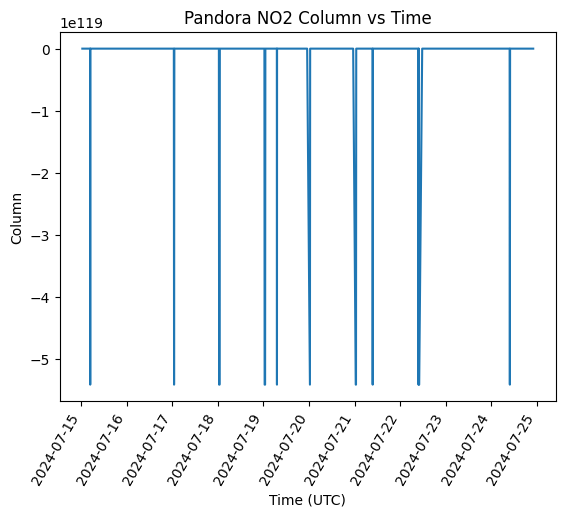

In [127]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.xticks(rotation=60, ha='right')
plt.title("Pandora NO2 Column vs Time")
plt.xlabel('Time (UTC)')
sns.lineplot(data=pgn_df, x='Time', y='Column')

Lets remove negative values, they seem to be otuliers.

<Axes: title={'center': 'Pandora NO2 Column vs Time'}, xlabel='Time (UTC)', ylabel='Column'>

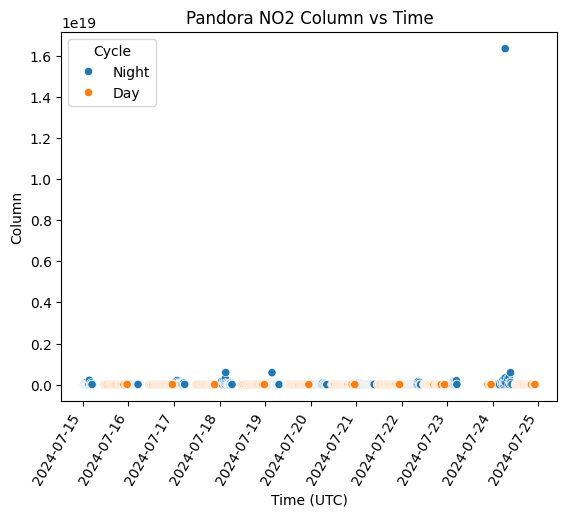

In [128]:
negative_filter = pgn_df.Column > 0
pgn_df = pgn_df[negative_filter]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title("Pandora NO2 Column vs Time")
plt.xlabel('Time (UTC)')
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

There's a max value that is likely meaningless and would skew even an outlier calculation.

<Axes: title={'center': 'Pandora NO2 Column vs Time'}, xlabel='Time (UTC)', ylabel='Column'>

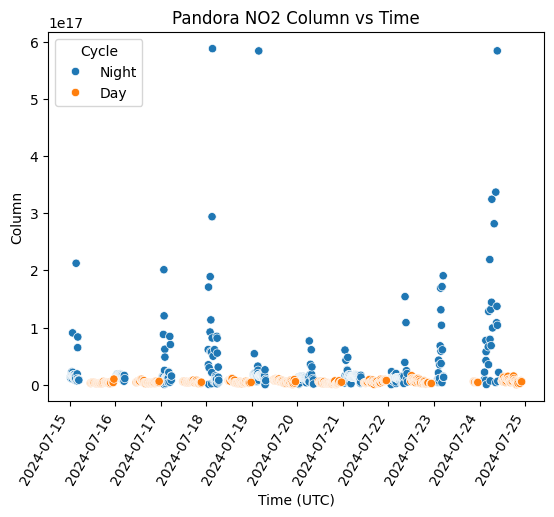

In [129]:
negative_filter = pgn_df.Column < 1e19
pgn_df = pgn_df[negative_filter]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title("Pandora NO2 Column vs Time")
plt.xlabel('Time (UTC)')
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

It seems that the outliers of nighttime and daytime data are on vary different scales.  Lets calculate and remove outliers on a per dataset basis.

<Axes: title={'center': 'Pandora NO2 Column vs Time'}, xlabel='Time (UTC)', ylabel='Column'>

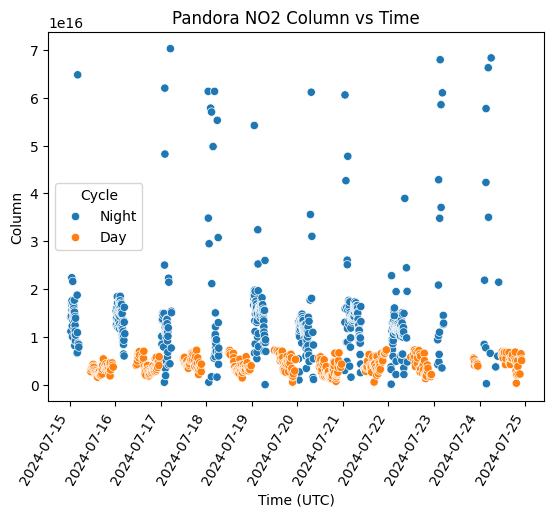

In [130]:
from matplotlib import pyplot as plt


# 3, 2, and 1 were tried, 1 offered the best results
outlier_stds = 1

# get daytime mask
day_mask = pgn_df.Cycle == 'Day'
night_mask = pgn_df.Cycle == 'Night'

day_mean = pgn_df[day_mask].Column.mean()
day_std = pgn_df[day_mask].Column.std()
day_cutoff = day_mean + (day_std * outlier_stds)
day_outlier_mask = night_mask | (pgn_df.Column < day_cutoff)

night_mean = pgn_df[night_mask].Column.mean()
night_std = pgn_df[night_mask].Column.std()
night_cutoff = night_mean + (night_std * outlier_stds)
night_outlier_mask = day_mask | (pgn_df.Column < night_cutoff)

outlier_mask = day_outlier_mask & night_outlier_mask

pgn_df = pgn_df[outlier_mask]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title("Pandora NO2 Column vs Time")
plt.xlabel('Time (UTC)')
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

Here, we see somewhat consistant coverage over the day.  Unfortunatly, since Lunear NO2 readings require moon visability, the quality, quantity, and coverage of nightitme readings varies significantly.  

To better understand the cyclical nature of the data, lets try plotting vs time of day, effectivly overlaying one day on top of the next to see if this helps to show the day night cycle trend.

In [131]:
list(range(0, 24, 4))

[0, 4, 8, 12, 16, 20]

<Axes: title={'center': 'Pandora NO2 Column vs Time of Day'}, xlabel='Hour of Day (ET)', ylabel='Column'>

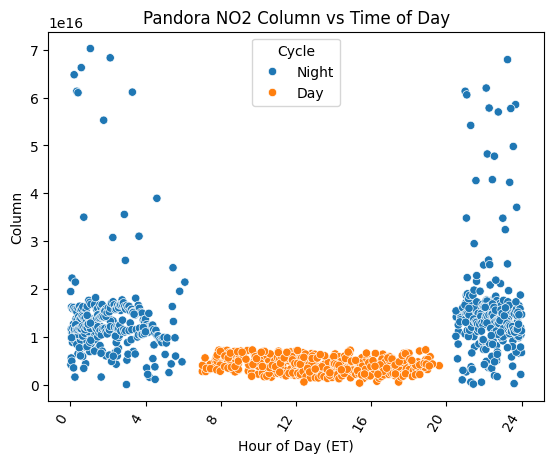

In [132]:
# convert to seconds since the linux epoch then get the remainder after deviding the seconds in a day to get time of day in seconds
pgn_df['TimeOfDay'] = (pgn_df.Time.astype(int) / 10**9) % 86400
pgn_df['MinOfDay'] = pgn_df['TimeOfDay'] / 60
pgn_df['HourOfDay'] = pgn_df['MinOfDay'] / 60
# convert to Eastern Time to make them easier to read
pgn_df['HourET'] = (pgn_df['HourOfDay'] - 4) % 24

fig, ax = plt.subplots()
plt.xticks(ticks=range(0, 25, 4), rotation=60, ha='right')
plt.title("Pandora NO2 Column vs Time of Day")
plt.xlabel('Hour of Day (ET)')
sns.scatterplot(data=pgn_df, x='HourET', y='Column', hue='Cycle')

#### Analysis

You an see that NO2 readings are lower between 7AM and 8PM, be telling of a data processing issue, but this notebok is meant to present a methodology for studying NO2 lifecycle and corrections may need to be made.  Lower, consistant values durring the day may be due to the fact that fewer cards are dirven durring day time.  NO2 builds up from 6-8 and then dies off overnight by the morning.  

It's also worth nothing that there are also some deadspots in the data where the sun and moon were not bright enough to provide a reading and depending on the moon cycle of the time frame chosen, there may not be any nighttime measruments available.

#### Load TEMPO

In [85]:
# raise Exception("This function takes too long to run")
tempo_df = pd.concat([pd.read_feather(p) for p in TEMPO_FILES], ignore_index=True) \
    .sort_values('Time')
print("TEMPO Data Shape:", tempo_df.shape)
tempo_df.head()

TEMPO Data Shape: (31346767, 5)


,Time,Latitude,Longitude,Column,Uncertainty
0,2024-07-15 10:51:22,58.587261,-64.150307,5.750755e+14,2.770604e+14
145762,2024-07-15 10:51:22,33.197407,-79.903862,1.763575e+15,6.882438e+14
145763,2024-07-15 10:51:22,33.179478,-79.906540,2.328641e+15,6.993905e+14
145764,2024-07-15 10:51:22,33.161533,-79.909233,1.808460e+15,6.552108e+14
145765,2024-07-15 10:51:22,33.143639,-79.911896,1.964411e+15,6.894301e+14


In [86]:
tempo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31346767 entries, 0 to 31346766
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Time         datetime64[ns]
 1   Latitude     float32       
 2   Longitude    float32       
 3   Column       float64       
 4   Uncertainty  float64       
dtypes: datetime64[ns](1), float32(2), float64(2)
memory usage: 1.2 GB


Create an hourly mean to make data it more reasonable to plot.

In [105]:
from datetime import timedelta


tempo_hourly_df = tempo_df.set_index('Time').resample(timedelta(hours=1)).mean()
print(tempo_hourly_df.shape)
tempo_hourly_df.head()

(205, 4)


,Latitude,Longitude,Column,Uncertainty
Time,,,,
2024-07-15 10:00:00,37.938366,-77.420418,2.422874e+15,9.326988e+14
2024-07-15 11:00:00,34.888107,-78.088303,1.904893e+15,9.027247e+14
2024-07-15 12:00:00,34.876667,-78.116913,1.524427e+15,1.018730e+15
2024-07-15 13:00:00,34.893982,-78.133553,1.302450e+15,1.055676e+15
2024-07-15 14:00:00,34.888706,-78.154144,1.068741e+15,1.094459e+15


<Axes: title={'center': 'TEMPO NO2 Column vs Time of Day'}, xlabel='Time (UTC)', ylabel='Column'>

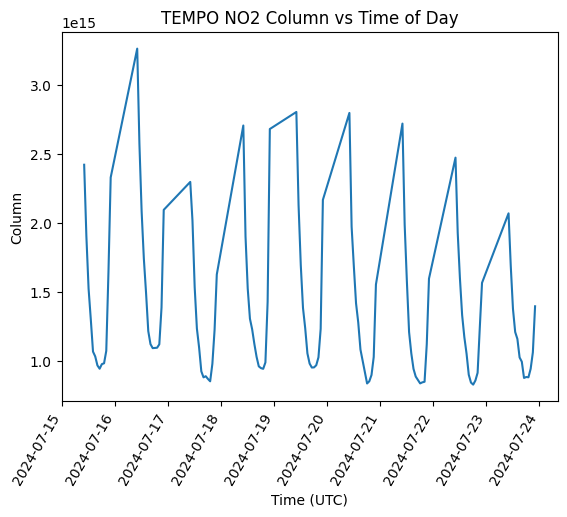

In [107]:
fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title("TEMPO NO2 Column vs Time of Day")
plt.xlabel('Time (UTC)')
sns.lineplot(data=tempo_hourly_df, x='Time', y='Column')

Here we see another bulid up and drove over the day night cycle.  Lets compare the descriptive statistics of this and the PGN dataset to ensure that the can be reasonably compared.  Also, a straight line can be seen at each peak where data is not found, this is the night cycle.

In [115]:
pgn_df[['Column']].describe().join(tempo_df[['Column']].describe(), lsuffix="PGN", rsuffix="TEMPO").sort_index(axis=1)

,ColumnPGN,ColumnTEMPO
count,1.184000e+03,3.134677e+07
mean,2.946634e+16,1.368433e+15
std,4.761340e+17,3.671590e+15
min,6.042014e+11,-4.987768e+17
25%,4.300486e+15,1.793685e+14
50%,9.265365e+15,7.859648e+14
75%,1.389127e+16,1.796814e+15
max,1.634108e+19,2.486635e+18


PGN values seem to have a higher mean and standard deviation than TMEPO.  For now I will just use a mix of TEMPO and PGN data to train a model.
**Future Work**
- Investigate why these numbers are different, is it just the sensors, is the difference neglidgable or statistically significant?
- Use a simple algorithm such as regression or random forest to map TEMPO values into PGN ranged values.
- When standardized, do the two dataset align?

Next, we'll extract a time of day column, similar to that in PGN.

<Axes: title={'center': 'TEMPO NO2 Column vs Time of Day'}, xlabel='Hour of Day (ET)', ylabel='Column'>

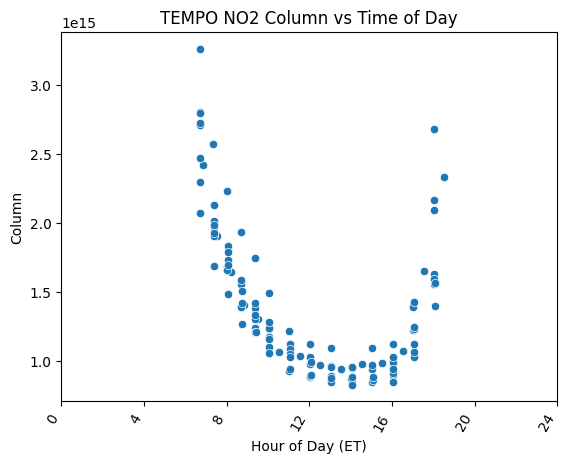

In [133]:
# convert to seconds since the linux epoch then get the remainder after deviding the seconds in a day to get time of day in seconds
tempo_df['TimeOfDay'] = (tempo_df.Time.astype(int) / 10**9) % 86400
tempo_df['MinOfDay'] = tempo_df['TimeOfDay'] / 60
tempo_df['HourOfDay'] = tempo_df['MinOfDay'] / 60
# convert to Eastern Time to make them easier to read
tempo_df['HourET'] = (tempo_df['HourOfDay'] - 4) % 24

fig, ax = plt.subplots()
plt.xticks(ticks=range(0, 25, 4), rotation=60, ha='right')
plt.xlim(0, 24)
plt.title("TEMPO NO2 Column vs Time of Day")
plt.xlabel('Hour of Day (ET)')
sns.scatterplot(data=tempo_df.set_index('Time').resample(timedelta(seconds=1)).mean(), x='HourET', y='Column')

**Analysis**<br>
We can see that column values range appears to be in roughly the same order of magnatude as the Pandora day observations.  We can also see a steep drop off around 8 AM and a steep rise around 6PM, which may match the much higher nighttime values observed in Pandora.

Finally, lets compare the TEMPO and Pandora daytime observations on the same chart to ensure they can be used togather.

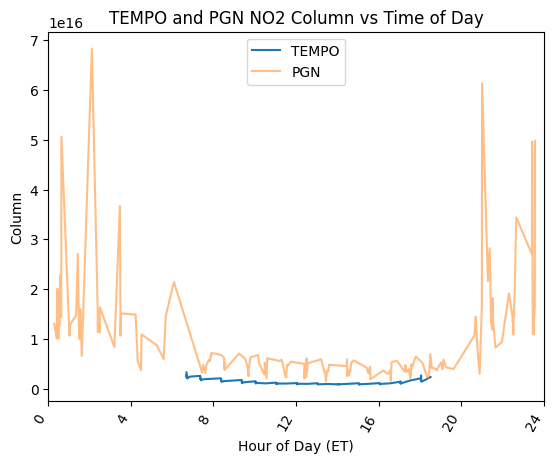

In [193]:
plot_cos = ['HourET', 'Time', 'Column']

fig, ax = plt.subplots()
plt.xticks(ticks=range(0, 25, 4), rotation=60, ha='right')
plt.xlim(0, 24)
plt.title("TEMPO and PGN NO2 Column vs Time of Day")
plt.xlabel('Hour of Day (ET)')
sns.lineplot(data=tempo_df[plot_cos].set_index('Time').resample(timedelta(hours=1)).mean(), x='HourET', y='Column', label='TEMPO')
sns.lineplot(data=pgn_df[plot_cos].set_index('Time').resample(timedelta(hours=1)).mean(), x='HourET', y='Column', alpha=0.5, label='PGN')
plt.legend()

**Analysis**<br>
When compared, it can be observed that TEMPO and PGN daytime day follow roughly the same pattern and that, although the nighttime data is much lower quality, a general trend exists.

### Data Modeling

In [ ]:
pgn_X_cols = ['TimeOfDay']
pgn_y_col = 'Column'

In [165]:
from sklearn.model_selection import train_test_split


# use X to produce y
X_train, X_test, Y_train, Y_test = train_test_split(
    pgn_df[pgn_X_cols],
    pgn_df[pgn_y_col],
    test_size=0.2,
    random_state=42
)

At first glance, this looks like a 3rd order polynomail, lets try that model first.

Running for polynomial of degree 1


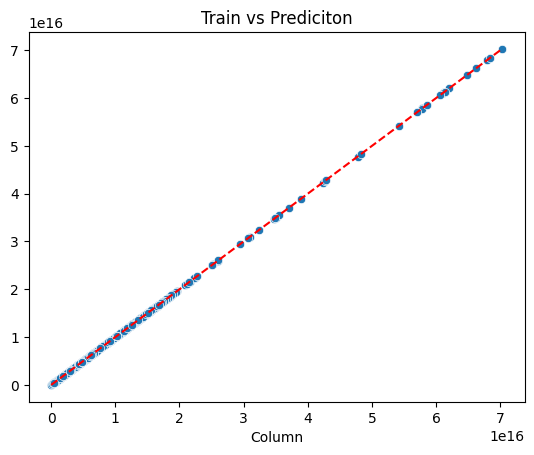

 6.458676e+00


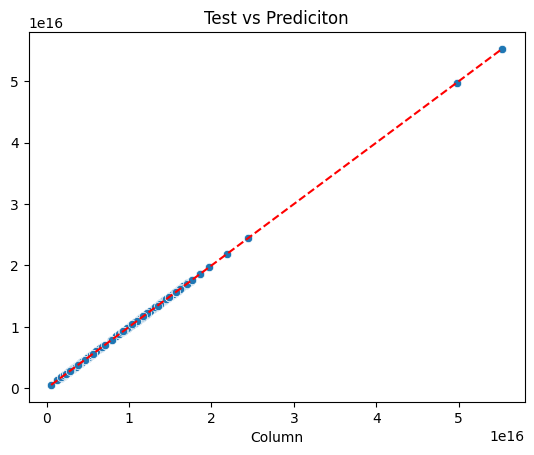

Running for polynomial of degree 2


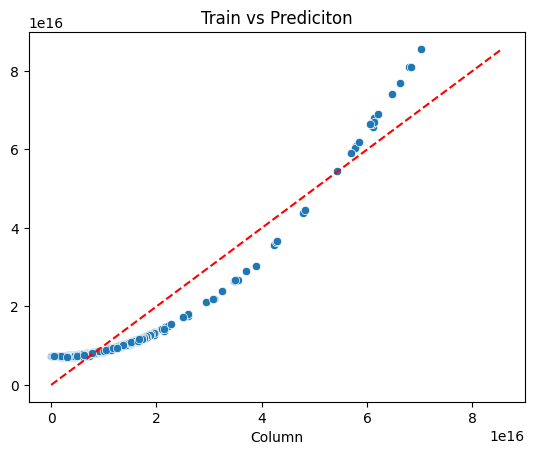

 3.674932e+15


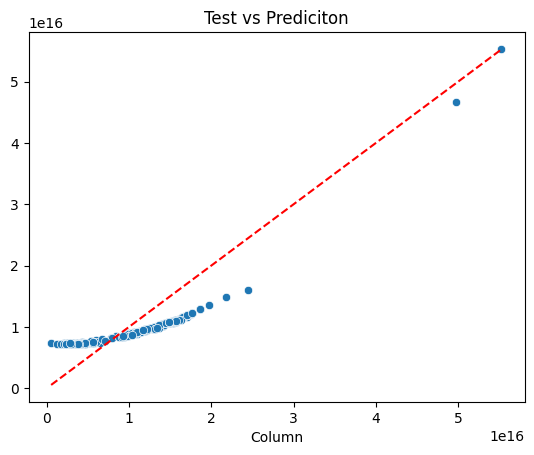

Running for polynomial of degree 3


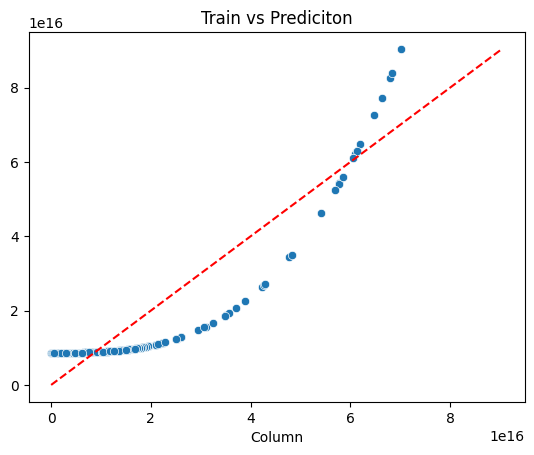

 4.973597e+15


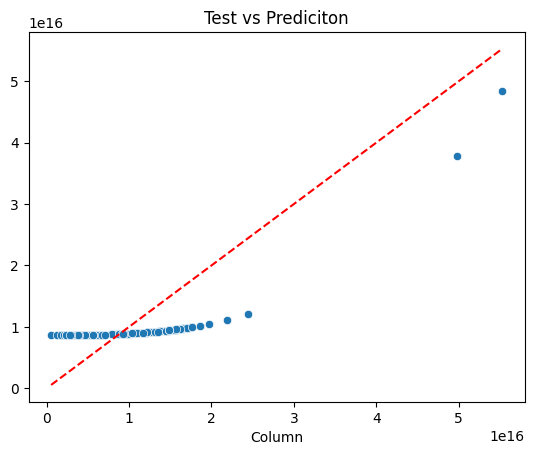

Running for polynomial of degree 4


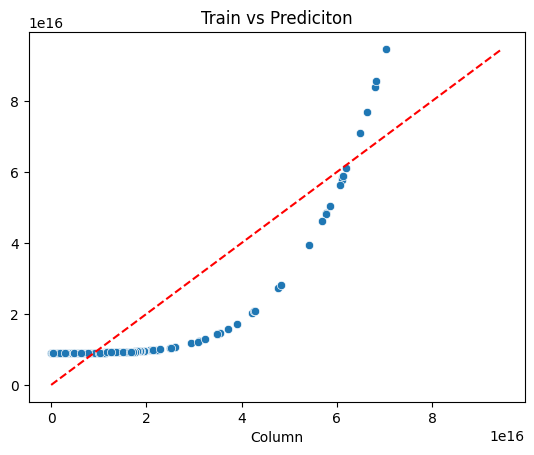

 5.430197e+15


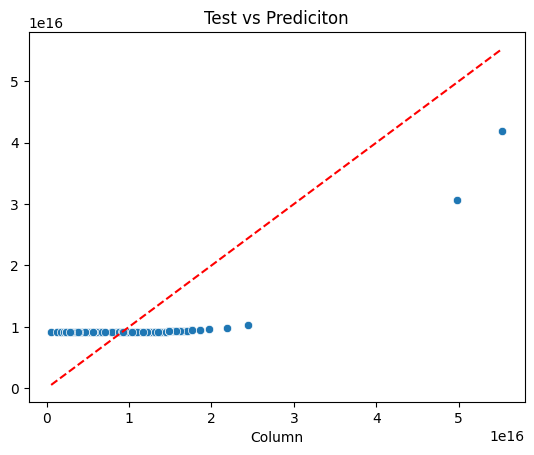

Running for polynomial of degree 5


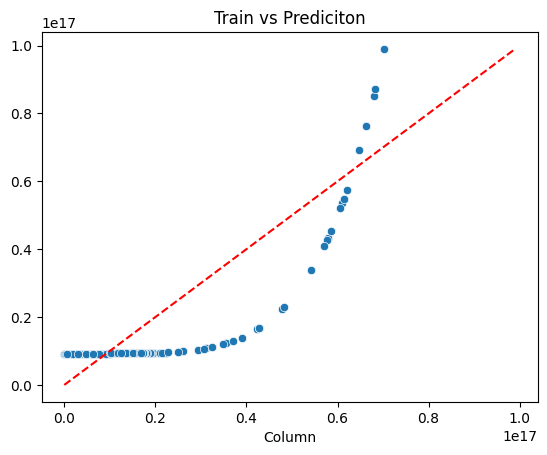

 5.683812e+15


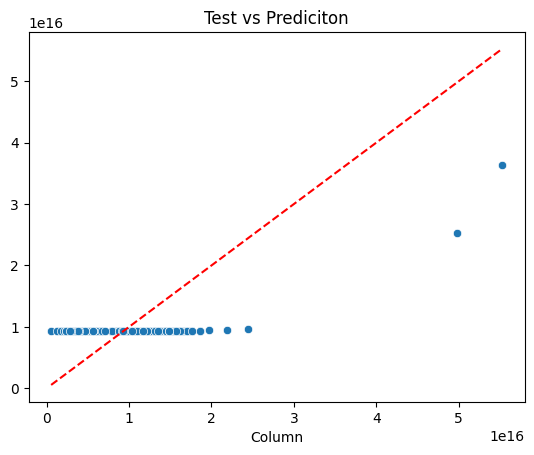

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


for degree in range(1, 6):
    print(f"Running for polynomial of degree {degree}")
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_poly, Y_train)
    Y_pred = model.predict(X_poly)

    ax = sns.scatterplot(x=Y_train, y=Y_pred)
    min_val = min(Y_train.min(), Y_pred.min())
    max_val = max(Y_train.max(), Y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')
    ax.set_title("Train vs Prediciton")
    poly_rmse = float(np.sqrt(mean_squared_error(Y_train, Y_pred)))
    plt.show()

    X_test_poly = poly_transformer.fit_transform(X_test)
    Y_test_pred = model.predict(X_test_poly)

    ax = sns.scatterplot(x=Y_test, y=Y_test_pred)
    min_val = min(Y_test.min(), Y_test_pred.min())
    max_val = max(Y_test.max(), Y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')
    ax.set_title("Test vs Prediciton")
    poly_rmse = float(np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
    print(f"RMSE {poly_rmse: e}")
    plt.show()
